# Warsztaty badawcze

## Budowa systemu rekomendacyjnego na podstawie danych z OLX Praca z wykorzystaniem metody GraphSAGE

#### Wiktoria Boguszewska, Mateusz Zacharecki, Patrycja Żak

## Opis metody GraphSAGE

GraphSAGE, czyli Graph Sample and Aggregate, to model sieci neuronowej, który efektywnie działa na danych strukturalnych takich jak grafy. Jego kluczowa innowacja to wykorzystanie techniki próbkowania sąsiedztwa wierzchołków, co pozwala na skalowanie do bardzo dużych grafów. GraphSAGE to metoda indukcyjnego uczenia się reprezentacji węzłów grafu. Pozwala na generowanie wektorów dla węzłów nawet w nowych, wcześniej niewidzianych częściach grafu, co odróżnia ją od transdukcyjnych metod, które wymagają znajomości całego grafu.

### Cel:
GraphSAGE ma na celu wygenerowanie reprezentacji węzłów grafu na podstawie informacji o lokalnym sąsiedztwie, a nie całej struktury. Dzięki temu może działać na dużych i dynamicznych grafach, takich jak sieci społeczne czy molekularne.

### Proces działania:
GraphSAGE działa poprzez wielowarstwową propagację w dół grafu, gdzie każda warstwa aktualizuje wektor reprezentacji węzła na podstawie agregacji wektorów jego sąsiadów.

### Algorytm:
Załóżmy, że mamy węzeł $v$ w grafie. Chcemy stworzyć jego wektor reprezentacji $h_v$ na podstawie sąsiedztwa.

WEJŚCIE:
- Graf $G = (V, E)$, gdzie $V$ to zbiór węzłów, a $E$ to zbiór krawędzi.
- Cechy węzłów $x_v$ dla każdego węzła $v \in V$.
- Zbiór sąsiadów $N(v)$ dla węzła $v$.

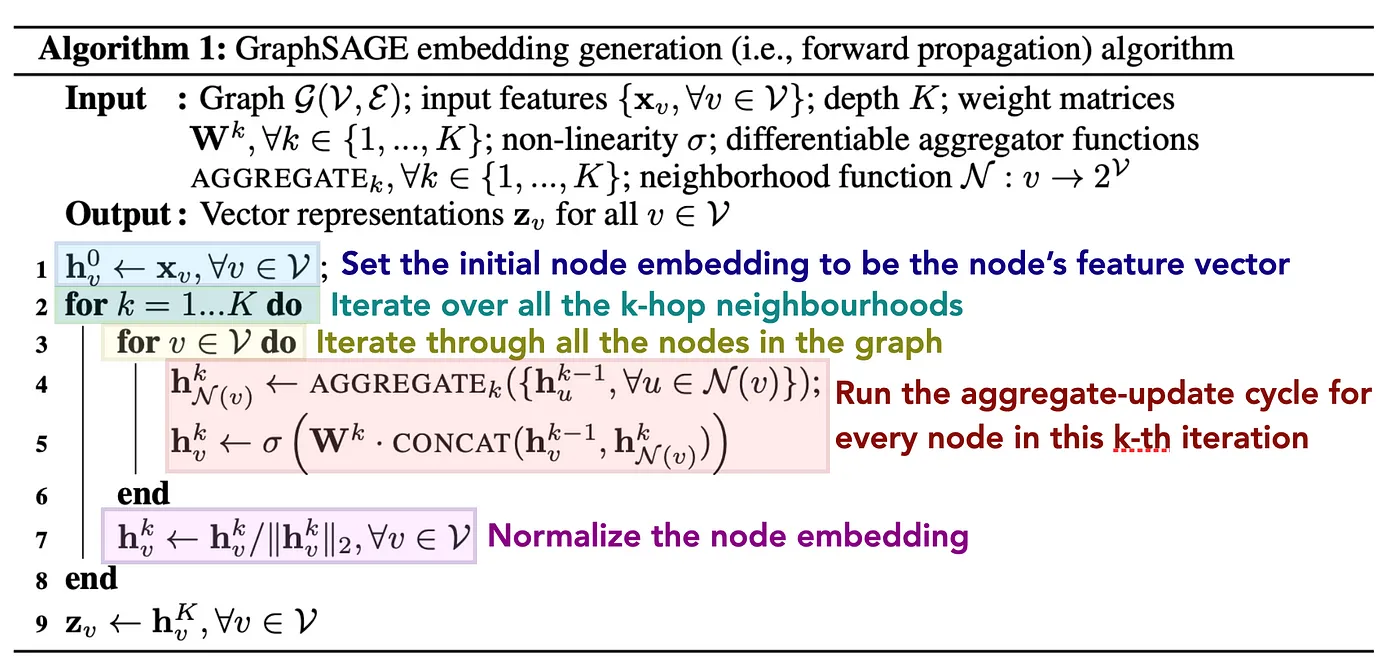



KROK 1 (Agregacja sąsiadów):

Dla każdego węzła $v$, algorytm pobiera cechy jego sąsiadów. Dla węzła $v$, reprezentacja jest aktualizowana poprzez agregację wektorów sąsiadów $u \in N(v)$. Agregacja może być przeprowadzona za pomocą różnych funkcji, np. średnia, LSTM, pooling.

KROK 2 (Aktualizacja węzła):

Po agregacji cech sąsiadów, GraphSAGE aktualizuje reprezentację węzła $v$. Na przykład, reprezentacja pochodząca z sąsiadów $h^{k+1}_v$ jest łączona z obecną reprezentacją węzła $h^k_v$ poprzez konkatenację:

$h^{k+1}_v = \sigma(W^k \cdot \text{concat}(h^k_v, \text{AGG}(h^k_u, \forall u \in N(v))))$,

gdzie $\text{AGG}$ to wybrana funkcja agregacji, a $\sigma$ to nieliniowa funkcja aktywacji.

WARSTWA KOŃCOWA:

Proces ten powtarza się przez kilka warstw $K$, w miarę jak GraphSAGE pobiera coraz dalsze informacje z grafu. Ostatecznie, wektor $h^K_v$ staje się końcową reprezentacją węzła $v$.

## Zalety i wady metody GraphSAGE

Zalety:
- Skalowalność na duże grafy.
- Umożliwia uczenie się osadzeń wierzchołków bezpośrednio z danych.
- Indukcyjność (GraphSAGE może generować reprezentacje dla węzłów, których nie było podczas trenowania).

Wady:
- Złożoność obliczeniowa związana z próbkowaniem sąsiedztwa.
- Może wymagać dużej ilości pamięci RAM do przetwarzania dużych grafów.

## Podsumowanie i zastosowania
GraphSAGE efektywnie wykorzystuje informacje zarówno o cechach wierzchołków, jak i strukturze grafu, co sprawia, że jest szczególnie przydatny w zastosowaniach takich jak systemy rekomendacyjne, gdzie można modelować i przewidywać interakcje użytkowników czy preferencje na podstawie danych strukturalnych. GraphSAGE znajduje zastosowanie w analizie sieci społecznych, rekomendacjach, bioinformatyce (np. modelowanie białek) oraz w dowolnym zadaniu, gdzie dane mają strukturę grafu.

## Zastosowanie metody GraphSAGE dla danych OLX Jobs Interactions

Wybraliśmy metodę GraphSAGE do analizy danych OLX Jobs Interactions, gdyż pozwala ona na efektywne generowanie osadzeń wierzchołków dla użytkowników i przedmiotów, co jest kluczowe w dynamicznym środowisku, gdzie użytkownicy regularnie wchodzą w interakcje z nowymi ogłoszeniami.

Zalety GraphSAGE w kontekście badanych danych:

- Indukcyjność: Model może generalizować na nowe wierzchołki (np. nowi użytkownicy lub ogłoszenia), które nie były obecne podczas treningu.
- Skalowalność: GraphSAGE efektywnie radzi sobie z dużymi grafami przez próbkowanie sąsiedztwa, co jest idealne przy obsłudze dużych ilości danych, jak w OLX.
- Aktualność: Możliwość szybkiego aktualizowania osadzeń pozwala na reagowanie na nowe trendy i preferencje użytkowników w czasie rzeczywistym.

Te cechy czynią GraphSAGE atrakcyjnym wyborem do budowania zaawansowanych systemów rekomendacyjnych, które mogą skutecznie personalizować treści na podstawie interakcji użytkowników, przewidując, jakie nowe ogłoszenia mogą ich zainteresować.

# Kod

Biblioteki do pobrania


In [1]:
!pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu118/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu118/repo.html


In [3]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn
from sklearn.metrics import precision_score, recall_score
from scipy.stats import uniform

In [4]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(dgl.__version__)

2.3.0+cu118
False
11.8
2.4.0+cu118


In [5]:
if torch.cuda.is_available():
    print("Masz dostęp do GPU:", torch.cuda.get_device_name(0))
else:
    print("Masz tylko CPU, brak GPU.")
    print(torch.version.cuda)

Masz tylko CPU, brak GPU.
11.8


Pracujemy z tym zbiorem danych (szczegóły w linku): https://www.kaggle.com/datasets/olxdatascience/olx-jobs-interactions

In [6]:
# Przetwarzanie wstępne

# Wczytanie pliku
data = pd.read_csv("interactions.csv")

# Filtracja tylko na kliknięcia
data = data[data['event'] == 'click']

# Ustaw początkowy i maksymalny procent próbkowania
initial_percentage = 0.05  # Zacznij od 5%
max_percentage = 0.50  # Zakończ na 50%
k = 10  # top-k rekomendacji

In [7]:
data.dtypes

user          int64
item          int64
event        object
timestamp     int64
dtype: object

In [8]:
data.head()

,user,item,event,timestamp
0,27901,56865,click,1581465600
1,124480,115662,click,1581465600
2,159509,5150,click,1581465600
3,188861,109981,click,1581465600
4,207348,88746,click,1581465600


In [9]:
# Zdefiniuj przestrzeń hiperparametrów do random search
hyperparameter_space = {
    'learning_rate': uniform(1e-4, 1e-2),  # Zakres learning rate
    'hidden_feats': [64, 128, 256],        # Możliwe rozmiary ukrytej warstwy
    'dropout': [0.0, 0.3, 0.5],            # Dropout
    'epochs': [10, 20, 30],                # Liczba epok
    'aggregator': ('mean', 'gcn', 'pool', 'lstm')    # Typ agregatora
}

# Funkcja do losowania hiperparametrów
def get_random_hyperparams(hyperparameter_space):
    return {
        'learning_rate': hyperparameter_space['learning_rate'].rvs(),
        'hidden_feats': random.choice(hyperparameter_space['hidden_feats']),
        'dropout': random.choice(hyperparameter_space['dropout']),
        'epochs': random.choice(hyperparameter_space['epochs']),
        'aggregator': random.choice(hyperparameter_space['aggregator'])
    }

In [10]:
# Konstrukcja grafu

def build_graph_and_train(sampling_percentage, hyperparams):
    print(f"Sampling at {sampling_percentage * 100}%")
    
    # Zmienne z losowanych hiperparametrów
    learning_rate = hyperparams['learning_rate']
    hidden_feats = hyperparams['hidden_feats']
    epochs = hyperparams['epochs']
    dropout = hyperparams['dropout']
    aggregator = hyperparams['aggregator']

    # Users
    user_unique = data['user'].unique()
    sample_size = int(len(user_unique) * sampling_percentage)
    sampled_users = np.random.choice(user_unique, size=sample_size, replace=False)

    # Przeiltruj interakcje dla wybranych użytkowników
    sampled_data = data[data['user'].isin(sampled_users)]

    # Items
    sampled_dist = sampled_data[['item', 'user']].drop_duplicates()
    item_count = sampled_dist.groupby('item').size().reset_index(name='count')
    item_count = item_count.sort_values(by='count', ascending=False)
    item_unique = sampled_data['item'].unique()
    sample_size = int(len(item_unique) * sampling_percentage)

    # Przeiltruj interakcje dla wybranych produktów
    sampled_items = item_count.iloc[:sample_size, :]['item'].tolist()
    sampled_data = sampled_data[sampled_data['item'].isin(sampled_items)]

    # Rozmiar danych
    print(f'Liczba obserwacji dla {sampling_percentage * 100}%: {sampled_data.shape[0]}')

    # Mapowanie użytkowników i elementów do indeksów
    user_to_idx = {user_id: idx for idx, user_id in enumerate(sampled_data['user'].unique())}
    item_to_idx = {item_id: idx for idx, item_id in enumerate(sampled_data['item'].unique())}

    # Zastosuj mapowania, aby utworzyć nową indeksowaną ramkę danych
    sampled_data.loc[:, 'user_idx'] = sampled_data['user'].map(user_to_idx)
    sampled_data.loc[:, 'item_idx'] = sampled_data['item'].map(item_to_idx)

    # Dostosuj item_idx, aby uniknąć nakładania się z user_idx poprzez przesunięcie indeksów elementów
    num_users = len(user_to_idx)
    sampled_data.loc[:, 'item_idx_shifted'] = sampled_data['item_idx'] + num_users  # Przesuń indeksy item o liczbę użytkowników

    # Utwórz krawędzie (interakcje użytkownik-produkt)
    edges = list(zip(sampled_data['user_idx'], sampled_data['item_idx_shifted']))

    # Stwórz graf DGL
    num_items = len(item_to_idx)
    num_total_nodes = num_users + num_items
    g = dgl.graph(edges, num_nodes=num_total_nodes)

    # Liczba userów, itemów, interakcji
    users = sampled_data['user'].unique()
    items = sampled_data['item'].unique()
    print(f'Liczba userów: {len(users)}')
    print(f'Liczba itemów: {len(items)}')
    print(f'Liczba interakcji: {len(edges)}')

    # Podziel dane na zestawy treningowe/testowe
    sampled_data = sampled_data.sort_values('timestamp')
    train_size = int(len(sampled_data) * 0.8)
    train_data = sampled_data[:train_size].copy()  # Kopia, aby uniknąć SettingWithCopyWarning
    test_data = sampled_data[train_size:].copy()

    # Dodaj etykietę 1 dla pozytywnych interakcji
    train_data['label'] = 1
    test_data['label'] = 1

    # Generowanie negatywnych przykładów

    # Funkcja do generowania negatywnych przykładów
    def generate_negative_samples(data, num_negatives):
        negative_samples = []
        all_users = data['user'].unique()
        all_items = data['item'].unique()
        user_item_set = set(zip(data['user'], data['item']))

        for user in all_users:
            negatives = 0
            while negatives < num_negatives:
                negative_item = np.random.choice(all_items)
                if (user, negative_item) not in user_item_set:
                    negative_samples.append([user, negative_item, 0])  # 0 jako etykieta negatywna
                    negatives += 1

        negative_df = pd.DataFrame(negative_samples, columns=['user', 'item', 'label'])
        return negative_df

    # Generowanie negatywnych przykładów dla treningu i testu
    num_negatives_per_user = 4  # Możesz dostosować tę wartość
    train_negatives = generate_negative_samples(train_data, num_negatives_per_user)
    test_negatives = generate_negative_samples(test_data, num_negatives_per_user)

    # Połączenie pozytywnych i negatywnych przykładów
    train_data = pd.concat([train_data[['user', 'item', 'user_idx', 'item_idx', 'item_idx_shifted', 'label']], train_negatives], ignore_index=True)
    test_data = pd.concat([test_data[['user', 'item', 'user_idx', 'item_idx', 'item_idx_shifted', 'label']], test_negatives], ignore_index=True)

    # Zaktualizuj indeksy dla negatywnych przykładów
    train_data['user_idx'] = train_data['user'].map(user_to_idx)
    train_data['item_idx'] = train_data['item'].map(item_to_idx)
    train_data['item_idx_shifted'] = train_data['item_idx'] + num_users

    test_data['user_idx'] = test_data['user'].map(user_to_idx)
    test_data['item_idx'] = test_data['item'].map(item_to_idx)
    test_data['item_idx_shifted'] = test_data['item_idx'] + num_users

    # Usuń wiersze z brakującymi wartościami (elementy spoza zbioru treningowego)
    train_data = train_data.dropna(subset=['user_idx', 'item_idx_shifted'])
    test_data = test_data.dropna(subset=['user_idx', 'item_idx_shifted'])

    # Konwersja indeksów do typu int
    train_data['user_idx'] = train_data['user_idx'].astype(int)
    train_data['item_idx_shifted'] = train_data['item_idx_shifted'].astype(int)
    test_data['user_idx'] = test_data['user_idx'].astype(int)
    test_data['item_idx_shifted'] = test_data['item_idx_shifted'].astype(int)

    # Inicjalizacja embeddingu

    # Utwórz embedding dla użytkowników i produktów
    user_emb = nn.Embedding(num_users, 64)  # 64-wymiar
    item_emb = nn.Embedding(num_items, 64)  # 64-wymiar

    # Definicja modelu

    class GraphSAGE(nn.Module):
        def __init__(self, in_feats, hidden_feats, out_feats, dropout, aggregator):
            super(GraphSAGE, self).__init__()
            self.conv1 = dgl.nn.SAGEConv(in_feats, hidden_feats, aggregator_type=aggregator)
            self.conv2 = dgl.nn.SAGEConv(hidden_feats, out_feats, aggregator_type=aggregator)
            self.dropout = nn.Dropout(dropout)
            self.fc = nn.Linear(out_feats, out_feats)  # Ostatnia warstwa do wyprowadzenia embeddingu

        def forward(self, g, features):
            h = self.conv1(g, features)
            h = torch.relu(h)
            h = self.dropout(h)
            h = self.conv2(g, h)
            h = torch.relu(h)
            h = self.fc(h)  # Embedding dla każdego węzła
            return h

    # Utwórz instancję modelu GraphSAGE
    model = GraphSAGE(in_feats=64, hidden_feats=hidden_feats, out_feats=64, dropout=dropout, aggregator=aggregator)

    # Kombinacja dla wszystkich węzłów

    def get_combined_features():
        user_tensor = torch.arange(num_users, dtype=torch.long)
        item_tensor = torch.arange(num_items, dtype=torch.long)

        # Wyodrębnij cechy użytkownika i przedmiotu
        user_features = user_emb(user_tensor)
        item_features = item_emb(item_tensor)

        # Połącz użytkownika i przedmiot do jednego tensora
        all_features = torch.cat([user_features, item_features], dim=0)
        return all_features

    # Konfiguracja

    optimizer = optim.Adam(list(model.parameters()) + list(user_emb.parameters()) + list(item_emb.parameters()), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()  # Użyj BCEWithLogitsLoss do klasyfikacji binarnej

    # Utwórz etykiety dla zestawów treningowych i testowych
    train_labels = torch.tensor(train_data['label'].values, dtype=torch.float32)
    test_labels = torch.tensor(test_data['label'].values, dtype=torch.float32)

    # Trening i ewaluacja pętli
    def train_model(epochs=20):
        for epoch in range(epochs):
            model.train()  # Ustawienie modelu do treningu
            optimizer.zero_grad()  # Wyczyszczenie gradientu

            # Uzyskaj połączone funkcje użytkowników i przedmiotów
            all_features = get_combined_features()

            # Forward pass
            output = model(g, all_features)

            # Wyodrębnij dane wyjściowe dla węzłów będących w krawędziach (zestaw treningowy)
            train_user_indices = torch.tensor(train_data['user_idx'].values, dtype=torch.long)
            train_item_indices = torch.tensor(train_data['item_idx_shifted'].values, dtype=torch.long)

            train_user_outputs = output[train_user_indices]
            train_item_outputs = output[train_item_indices]

            # Oblicz skalarne produkty jako przewidywania
            train_edge_outputs = torch.sum(train_user_outputs * train_item_outputs, dim=1)

            # Oblicz stratę
            train_loss = loss_fn(train_edge_outputs, train_labels)

            # Backward pass i optymalizacja
            train_loss.backward()
            optimizer.step()
            
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss.item():.4f}")

        # Ewaluacja na zbiorze testowym
        model.eval()
        with torch.no_grad():
            # Uzyskaj połączone funkcje użytkowników i przedmiotów
            all_features = get_combined_features()

            # Forward pass
            output = model(g, all_features)

            # Oddziel embeddingi użytkowników i przedmiotów
            user_embeddings = output[:num_users]  # shape (num_users, embedding_dim)
            item_embeddings = output[num_users:]  # shape (num_items, embedding_dim)

            # Lista unikalnych użytkowników w zbiorze testowym
            test_user_indices = test_data['user_idx'].unique()

            k = 10  # Top-k rekomendacji

            user_precisions = []
            user_recalls = []

            for user_idx in test_user_indices:
                user_idx = int(user_idx)
                user_embedding = user_embeddings[user_idx]  # Embedding użytkownika

                # Oblicz skalarne produkty z wszystkimi przedmiotami
                scores = torch.matmul(item_embeddings, user_embedding)

                # Uzyskaj top-k przedmiotów
                top_k = torch.topk(scores, k=k)
                top_k_item_indices = top_k.indices.cpu().numpy()

                # Faktyczne przedmioty, z którymi użytkownik wchodził w interakcje w zbiorze testowym
                actual_items = test_data[test_data['user_idx'] == user_idx]['item_idx'].values

                if len(actual_items) == 0:
                    continue  # Pomiń użytkowników bez interakcji w zbiorze testowym

                # Oblicz liczbę trafnych rekomendacji
                num_relevant_items = len(actual_items)
                num_recommended_items = k
                num_relevant_recommended_items = len(set(top_k_item_indices) & set(actual_items))

                # Oblicz precision i recall dla tego użytkownika
                precision = num_relevant_recommended_items / num_recommended_items
                recall = num_relevant_recommended_items / num_relevant_items

                user_precisions.append(precision)
                user_recalls.append(recall)

            # Oblicz średnie precision i recall
            if user_precisions:
                avg_precision = np.mean(user_precisions)
            else:
                avg_precision = 0.0
            if user_recalls:
                avg_recall = np.mean(user_recalls)
            else:
                avg_recall = 0.0

            return avg_precision, avg_recall

    # Wywołanie funkcji treningu
    precision, recall = train_model(epochs=epochs)
    return precision, recall

In [11]:
# Randomized Search
def randomized_search(sampling_percentage, n_trials=10):
    best_precision = 0
    best_hyperparams = None
    results = []

    for trial in range(n_trials):
        hyperparams = get_random_hyperparams(hyperparameter_space)
        precision, recall = build_graph_and_train(sampling_percentage, hyperparams)
        results.append((hyperparams, precision, recall))

        if precision > best_precision:
            best_precision = precision
            best_hyperparams = hyperparams

        print(f"Trial {trial + 1}/{n_trials}: Hyperparameters: {hyperparams}, Precision@{k} = {precision:.4f}, Recall@{k} = {recall:.4f}")
    
    print(f"Best hyperparameters: {best_hyperparams}, Best Precision@{k}: {best_precision:.4f}")
    return best_hyperparams, results

# Wywołanie Randomized Search
best_hyperparams, results = randomized_search(sampling_percentage=0.01, n_trials=20)

Sampling at 1.0%
Liczba obserwacji dla 1.0%: 23329
Liczba userów: 6683
Liczba itemów: 770
Liczba interakcji: 23329


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 1/10, Loss: 4.7524
Epoch 2/10, Loss: 1.9120
Epoch 3/10, Loss: 0.9620
Epoch 4/10, Loss: 0.7517
Epoch 5/10, Loss: 0.7153
Epoch 6/10, Loss: 0.7265
Epoch 7/10, Loss: 0.7458
Epoch 8/10, Loss: 0.7342
Epoch 9/10, Loss: 0.7076
Epoch 10/10, Loss: 0.7004
Trial 1/20: Hyperparameters: {'learning_rate': 0.0034971469359133486, 'hidden_feats': 64, 'dropout': 0.5, 'epochs': 10, 'aggregator': 'gcn'}, Precision@10 = 0.0127, Recall@10 = 0.0187
Sampling at 1.0%
Liczba obserwacji dla 1.0%: 23131
Liczba userów: 6763
Liczba itemów: 771
Liczba interakcji: 23131
Epoch 1/30, Loss: 3.0578
Epoch 2/30, Loss: 0.9471
Epoch 3/30, Loss: 0.8499
Epoch 4/30, Loss: 0.7660
Epoch 5/30, Loss: 0.7200
Epoch 6/30, Loss: 0.7026
Epoch 7/30, Loss: 0.6963
Epoch 8/30, Loss: 0.6935
Epoch 9/30, Loss: 0.6919
Epoch 10/30, Loss: 0.6906
Epoch 11/30, Loss: 0.6893
Epoch 12/30, Loss: 0.6877
Epoch 13/30, Loss: 0.6860
Epoch 14/30, Loss: 0.6840
Epoch 15/30, Loss: 0.6820
Epoch 16/30, Loss: 0.6798
Epoch 17/30, Loss: 0.6776
Epoch 18/30, Loss

In [ ]:
# Pętla, aby stopniowo zwiększać procent próbkowania
current_percentage = initial_percentage
while current_percentage <= max_percentage:
    precision, recall = build_graph_and_train(current_percentage, best_hyperparams)
    print(f"Precision@{current_percentage} = {precision:.4f}, Recall@{current_percentage} = {recall:.4f}")
    current_percentage += 0.05  # Zwiększaj o 5%

Sampling at 5.0%
Liczba obserwacji dla 5.0%: 442161
Liczba userów: 66510
Liczba itemów: 5826
Liczba interakcji: 442161
Epoch 1/10, Loss: 2.5722
Epoch 2/10, Loss: 1.4096
Epoch 3/10, Loss: 0.8587
Epoch 4/10, Loss: 0.6975
Epoch 5/10, Loss: 0.6710
Epoch 6/10, Loss: 0.6671
Epoch 7/10, Loss: 0.6763
Epoch 8/10, Loss: 0.6905
Epoch 9/10, Loss: 0.6880
Epoch 10/10, Loss: 0.6788
Precision@0.05 = 0.0022, Recall@0.05 = 0.0025
Sampling at 10.0%
Liczba obserwacji dla 10.0%: 1381551
Liczba userów: 160121
Liczba itemów: 12766
Liczba interakcji: 1381551
Epoch 1/10, Loss: 2.9185
Epoch 2/10, Loss: 1.6386
Epoch 3/10, Loss: 0.9506
Epoch 4/10, Loss: 0.6991
Epoch 5/10, Loss: 0.6582
Epoch 6/10, Loss: 0.6528
Epoch 7/10, Loss: 0.6422
Epoch 8/10, Loss: 0.6545
Epoch 9/10, Loss: 0.6800
Epoch 10/10, Loss: 0.6815
Precision@0.1 = 0.0011, Recall@0.1 = 0.0011
Sampling at 15.000000000000002%
Liczba obserwacji dla 15.000000000000002%: 2587720
Liczba userów: 262409
Liczba itemów: 19963
Liczba interakcji: 2587720
Epoch 1/10,

#### 25%
Liczba obserwacji dla 25.0%: 5561617

Liczba userów: 477630

Liczba itemów: 35031

Liczba interakcji: 5561617

Dobrane hiperparametry: learning_rate: 0.007969829704578178, hidden_feats: 256, dropout: 0.3, epochs: 30, aggregator: 'lstm'

Precision@25: 0.0004, Recall@25: 0.0004

## Rozwiązanie

W celu nie dopuszczenia do sytuacji złego doboru modelu GraphSage w przyszłości, przygotowaliśmy analizę, która może pomóc w podjęciu takiej decyzji.

In [16]:
len_graphs = len(graph_list)
get_one_random_graph = random.randint(0,len_graphs-1)
chosen_graph = graph_list[get_one_random_graph]

Gęstość grafu: 0.00010491665430217651


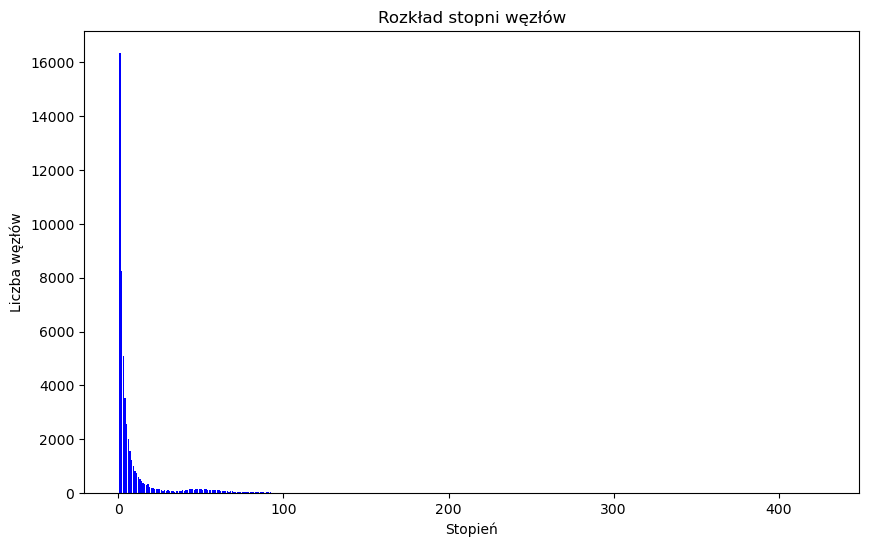

Średni stopień węzła: 11.328690498240414
Graf spójny: True


In [18]:
import networkx as nx
from collections import Counter

# Konwersja grafu DGL do grafu NetworkX
nx_g = chosen_graph.to_networkx()

# 1. Gęstość grafu
density = nx.density(nx_g)
print(f"Gęstość grafu: {density}")

# 2. Rozkład stopni węzłów
degree_sequence = [d for _, d in nx_g.degree()]
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10,6))
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Rozkład stopni węzłów")
plt.xlabel("Stopień")
plt.ylabel("Liczba węzłów")
plt.show()

# 3. Średni stopień węzła
avg_degree = np.mean(degree_sequence)
print(f"Średni stopień węzła: {avg_degree}")

# 4. Spójność grafu
is_connected = nx.is_connected(nx_g.to_undirected())
print(f"Graf spójny: {is_connected}")


Jak widać po wynikach, graf jest bardzo rzadki, co oznacza, że większość potencjalnych połączeń między węzłami nie istnieje. Wynika z tego, że użytkownicy mają interakcje tylko z kilkoma przedmiotami. Średnio każdy węzeł ma około 11 sąsiadów, co nie jest niskim wynikiem. Graf jest spójny, co oznacza, że istnieje ścieżka między każdym użytkownikiem a przedmiotem w grafie.

## Bibliografia:
1. https://medium.com/analytics-vidhya/ohmygraphs-graphsage-and-inductive-representation-learning-ea26d2835331
2. https://www.dgl.ai/pages/start.html
3. https://medium.com/stanford-cs224w/friend-recommendation-using-graphsage-ffcda2aaf8d6